In [1]:
import Topyfic
import pandas as pd
import scanpy as sc
import numpy as np
import sys
import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata
from scipy.spatial import distance
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
import scanpy.external as sce
import math
import networkx as nx
from adjustText import adjust_text
import matplotlib.backends.backend_pdf


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/apps/python/3.8.0/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
def calculate_num(analysis_top_model, threshold=0.8):
    cell_participation = analysis_top_model.cell_participation.to_df()
    res = pd.DataFrame(columns=["num"], index=cell_participation.index)
    
    for i in range(cell_participation.shape[0]):
        tmp = cell_participation.sort_values(by=cell_participation.index[i], axis=1, ascending=False).iloc[i, :]
        count = 1
        total_sum = 0
        
        for j in range(analysis_top_model.top_model.N):
            total_sum += tmp[j]
            if total_sum >= threshold:
                break
            count += 1
        res.iloc[i, 0] = count
        
    return res

# Fig. 3a

In [67]:
analysis_adrenal = Topyfic.read_topModel("../snrna/adrenal/topyfic/analysis_10x_adrenal_15_parse_adrenal_13.p")
analysis_cortex = Topyfic.read_topModel("../snrna/cortex/topyfic/analysis_10x_cortex_14_parse_cortex_13.p")
analysis_hippocampus = Topyfic.read_topModel("../snrna/hippocampus/topyfic/analysis_10x_hipp_13_parse_hipp_12.p")
analysis_heart = Topyfic.read_topModel("../snrna/heart/topyfic/analysis_10x_heart_11_parse_heart_13.p")
analysis_gastrocnemius= Topyfic.read_topModel("../snrna/gastrocnemius/topyfic/analysis_10x_gastrocnemius_12_parse_gastrocnemius_8.p")


Reading TopModel done!
Reading TopModel done!
Reading TopModel done!
Reading TopModel done!
Reading TopModel done!


In [68]:
# Run the calculate_num function for each tissue
tissues = ['adrenal', 'cortex', 'hippocampus', 'gastrocnemius', 'heart']
results = {}

for tissue in tissues:
    analysis_tissue = globals()[f'analysis_{tissue}']
    tmp = calculate_num(analysis_tissue, 0.8).value_counts()
    tmp = tmp / tmp.sum() * 100
    results[tissue] = tmp

# Create a merged DataFrame from the results
merged_results = pd.DataFrame(results)
merged_results.index.name = 'num'
merged_results = merged_results.sort_index(ascending=False, axis=0)
merged_results = merged_results[tissues]



In [69]:
merged_results.to_csv("data/fig3a_topic_participation_summary.csv")


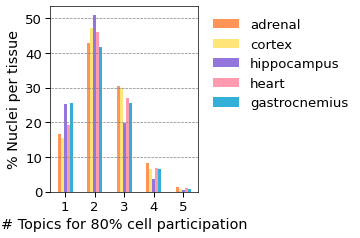

In [3]:
# Read the data from the CSV file
res = pd.read_csv("data/fig3a_topic_participation_summary.csv")
res.dropna(axis=0, how='all', inplace=True)
res = res.fillna(0)
res = res[~res['num'].isin([6, 7, 8])]
res.index = res['num']

# Reorder columns to desired order
desired_order = ['adrenal', 'cortex', 'hippocampus', 'heart', 'gastrocnemius']
res = res[desired_order]

# Set up matplotlib parameters for font and PDF font type
mpl.rcParams['pdf.fonttype'] = 42

# Create a bar plot with specified colors
ax = res.iloc[::-1].plot(kind='bar',  # Reverse the DataFrame for reverse plotting order
                        stacked=False,
                        figsize=(2.65, 3.405),
                        color = ['#ff9458', '#ffe578' ,'#9376dc', '#ff9aaf', '#34b0d8'])

ax.set_xlabel("# Topics for 80% cell participation")
ax.set_ylabel("% Nuclei per tissue")

# Add a legend for tissue labels outside the plot
ax.legend(res.columns, frameon=False, bbox_to_anchor=(1.02, 1), loc='upper left')

# Add dashed lines at specific y-values
for y_value in [10, 20, 30, 40, 50]:
    ax.hlines(y_value, xmin=-1, xmax=res.shape[0], 
              linestyles="dashed", color="grey", linewidth = 0.7)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    # Set the border thickness around the entire plot
for spine in ax.spines.values():
    spine.set_linewidth(0.7)  # Adjust linewidth as needed

fig = ax.get_figure()


In [4]:
fig.savefig('fig3/fig3a_active_cells_topics_0.8.pdf', bbox_inches='tight')



In [5]:
fig.savefig('fig3/fig3a_active_cells_topics_0.8.png', bbox_inches='tight', dpi=1200)


# Fig. 3b

Violin plot of cell participation across tissues, colored by enriched cell type / state

In [6]:
# Nested dictionary of topic colors for different tissues
topic_colors = {
    "adrenal": {
        f"Topic_{i+1}": color for i, color in enumerate([
            '#FD8D3C', '#31A354', '#DE2D26', '#a75628', '#9df63a', '#A63603',
            '#FD8D3C', '#BCBDDC', '#FD8D3C', '#c6c6c6c6', '#c6c6c6c6', '#E6550D',
            '#31A354', '#dd77ae', '#ffd92e', '#c6c6c6c6', '#c6c6c6c6', '#BCBDDC', '#756BB1'
        ])
    },
    "cortex": {
        f"Topic_{i+1}": color for i, color in enumerate([
            '#938FC2', '#938FC2', '#75eacf', '#b29471', '#31A354', '#75eacf',
            '#ccad23', '#dd77ae', '#ffec96', '#938FC2', '#31A354', '#5D3A98',
            '#DE2D26', '#624128', '#A8A6CF', '#E5E4F0'
        ])
    },
    "hippocampus": {
        f"Topic_{i+1}": color for i, color in enumerate([
            '#75eacf', '#938FC2', '#E5E4F0', '#ccad23', '#938FC2', '#b29471',
            '#31A354', '#938FC2', '#BEBFDD', '#ffec96', '#31A354', '#dd77ae',
            '#5D3A98', '#c6c6c6c6'
        ])
    },
    "heart": {
        f"Topic_{i+1}": color for i, color in enumerate([
            '#ffd92e', '#f58581', '#dd77ae', '#ffd92e', '#c6c6c6c6', '#9df63a',
            '#31A354', '#ef6647', '#455440', '#31A354', '#f58581', '#a75628',
            '#f58581', '#31A354', '#31A354', '#f58581', '#31A354'
        ])
    },
    "gastrocnemius": {
        f"Topic_{i+1}": color for i, color in enumerate([
            '#c6c6c6c6', '#08306B', '#08306B', '#a75628', '#08306B', '#08519C',
            '#31A354', '#9ECAE1', '#b0d419', '#dd77ae', '#a75628', '#40beb4',
            '#578a9f', '#08306B', '#9ECAE1', '#6BAED6'
        ])
    }
}

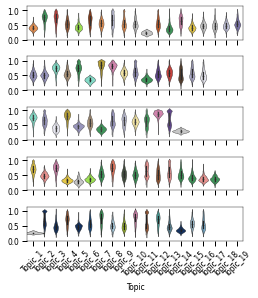

In [7]:
# List of tissues
tissues = ["adrenal", "cortex", "hippocampus", "heart", "gastrocnemius"]

# Create subplots with shared x-axis
fig, axarr = plt.subplots(len(tissues), 1, figsize=(3.7, 4.25), sharex=True)

plt.subplots_adjust(hspace=0.001)  # You can adjust the value to control the spacing

# Loop through each tissue
for i, tissue in enumerate(tissues):
    # Load data for the current tissue
    df = pd.read_csv(f"data/{tissue}_cell_participation.csv", index_col=0)

    # Get the top topic for each cell
    top_topic = np.argmax(df.values, axis=1) + 1

    # Create a new data frame with cell IDs and their top topics
    top_topics_df = pd.DataFrame({"Cell": df.index, "Top_Topic": [f"Topic_{i}" for i in top_topic]})

    # Gather the data for plotting
    df_long = pd.melt(df.reset_index(), id_vars="index", var_name="Topic", value_name="Cell_participation")
    df_long = df_long.merge(top_topics_df, left_on="index", right_on="Cell")
    df_long = df_long[df_long["Cell_participation"] > 0.05].sort_values("Cell")

    df_long = df_long[df_long["Topic"] == df_long["Top_Topic"]]
    df_long["Top_Topic"] = pd.Categorical(df_long["Top_Topic"], categories=[f"Topic_{i}" for i in range(1, 20)])

    # Get the palette for the current tissue from the nested dictionary
    current_palette = list(topic_colors[tissue].values())

    
    # Define tissue-specific widths using a dictionary
    tissue_widths = {
        'adrenal': 1.0,
        'cortex': 1.0,
        'hippocampus': 1.5,
        'heart': 1.0,
        'gastrocnemius': 2
    }

    # Determine the width parameter based on the tissue
    width = tissue_widths.get(tissue, 1.0)
    

    # Create a violin plot with the current palette and width parameter
    sns.violinplot(data=df_long, x="Top_Topic", y="Cell_participation", 
                   linewidth=0.4, width=width, palette=current_palette, ax=axarr[i])
    
    axarr[i].set_ylabel("")  # Adjust fontsize as needed
    axarr[i].tick_params(axis='both', which='major', labelsize=7.5)  # Adjust tick label fontsize
    axarr[i].set_xlabel("")  # Remove x-axis label
    axarr[i].set_xticklabels(axarr[i].get_xticklabels(), rotation=45)
    
    
    # Set y-axis tick positions and labels
    axarr[i].set_yticks([0.0, 0.5, 1.0])
    axarr[i].set_yticklabels(["0.0", "0.5", "1.0"])


    # Set the border thickness around the plot
    for spine in axarr[i].spines.values():
        spine.set_linewidth(0.4)  # Adjust linewidth as needed

# Set common x-axis label
axarr[-1].set_xlabel("Topic", fontsize=7.5)  # Adjust fontsize as needed

plt.tight_layout()

plt.show()  # Show the plot


In [9]:
fig.savefig('fig3/fig3b_all_topic_cell_participation_violin.pdf', bbox_inches='tight')



In [10]:
fig.savefig('fig3/fig3b_all_topic_cell_participation_violin.png', bbox_inches='tight', dpi=1200)


# Fig. 3c

In [119]:
def MA_plot(topic1,
            topic2,
            size=None,
            pseudocount=1,
            threshold=1,
            cutoff=2.0,
            consistency_correction=1.4826,
            #topN=None,
            labels=None,
            save=True,
            show=True,
            file_format="pdf",
            file_name="MA_plot"):
    """
        plot MA based on the gene weights on given topics

        :param topic1: gene weight of first topic to be compared
        :type topic1: pandas.series
        :param topic2: gene weight of second topic to be compared
        :type topic2: pandas.series
        :param size: table contains size of dot for each genes (genes are index)
        :type size: pandas dataframe
        :param pseudocount: pseudocount that you want to add (default: 1)
        :type pseudocount: float
        :param threshold: threshold to filter genes based on A values (default: 1)
        :type threshold: float
        :param cutoff: cutoff for categorized genes by modified z-score (default: 2)
        :type cutoff: float
        :param consistency_correction: the factor converts the MAD to the standard deviation for a given distribution. The default value (1.4826) is the conversion factor if the underlying data is normally distributed
        :type consistency_correction: float
        :param topN: number of genes to be consider for calculating z-score based on the A value (if it's none is gonna be avarage of # genes in both topics with weights above threshold
        :type topN: int
        :param labels: list of gene names wish to show in MA-plot
        :type labels: list
        :param save: indicate if you want to save the plot or not (default: True)
        :type save: bool
        :param show: indicate if you want to show the plot or not (default: True)
        :type show: bool
        :param file_format: indicate the format of plot (default: pdf)
        :type file_format: str
        :param file_name: name and path of the plot use for save (default: MA_plot)
        :type file_name: str

        :return: return M and A values
        """
    topic1 += pseudocount
    topic2 += pseudocount

    A = (np.log2(topic1) + np.log2(topic2)) / 2
    M = np.log2(topic1) - np.log2(topic2)

    # if topN is None:
    #     len_topic1 = sum(topic1 > threshold)
    #     len_topic2 = sum(topic2 > threshold)
    #     topN = round((len_topic1 + len_topic2) / 2)

    gene_zscore = pd.concat([A, M], axis=1)
    gene_zscore.columns = ["A", "M"]
    gene_zscore = gene_zscore[gene_zscore.A > threshold]

    if size is not None:
        size = size.loc[gene_zscore.index, :]
        gene_zscore = pd.concat([gene_zscore, size], axis=1)
        gene_zscore.columns = ["A", "M", "size"]

    gene_zscore.sort_values('A', ascending=False, inplace=True)
    #gene_zscore = gene_zscore.iloc[:topN, :]

    gene_zscore['mod_zscore'], mad = modified_zscore(gene_zscore['M'],
                                                     consistency_correction=consistency_correction)
    fig, ax = plt.subplots(figsize=(4.5, 2.5))

    if gene_zscore.shape[0] == 0:
        print("there is no genes that pass the threshold!")
        return gene_zscore
    plot_df = gene_zscore.copy(deep=True)
    plot_df.mod_zscore = plot_df.mod_zscore.abs()
    plot_df.mod_zscore[plot_df.mod_zscore > cutoff] = cutoff
    plot_df.mod_zscore[plot_df.mod_zscore < cutoff] = 0
    plot_df.mod_zscore.replace(float('-inf'), -1*cutoff)
    plot_df.mod_zscore.replace(float('inf'), cutoff)
    plot_df.mod_zscore.fillna(0, inplace=True)
    plot_df.mod_zscore = plot_df.mod_zscore.astype(str)
    plot_df.mod_zscore[plot_df.mod_zscore == str(cutoff)] = f'> {cutoff}'
    plot_df.mod_zscore[plot_df.mod_zscore == '0.0'] = f'< {cutoff}'

    if labels is None:
        plot_df['label'] = ""
    else:
        plot_df['label'] = plot_df.index.tolist()
        plot_df.label[~plot_df.label.isin(labels)] = ""

    y = plot_df.M.median()
    ymin = y - consistency_correction * mad * cutoff
    ymax = y + consistency_correction * mad * cutoff
    xmin = round(plot_df.A.min()) - 1
    xmax = round(plot_df.A.max())
    if size is None:
        plot_df.columns = ["A", "M", "abs(mod_Zscore)", "label"]
    else:
        plot_df.columns = ["A", "M", "#topics GW >= 1", "abs(mod_Zscore)", "label"]

    color_palette = {f'> {cutoff}': "#9376dc",
                     f'< {cutoff}': "#a3a3a3"}
    markers = {f'> {cutoff}': "o",
               f'< {cutoff}': "s"}

    plt.ylim(-10, 10)
    
    if size is None:
        sns.scatterplot(data=plot_df, x="A", y="M", style="abs(mod_Zscore)", hue="abs(mod_Zscore)",
                        markers=markers, palette=color_palette, linewidth=0.1)
    else:
        sns.scatterplot(data=plot_df, x="A", y="M", style="abs(mod_Zscore)", hue="#topics GW >= 1",
                        linewidth=0.1, markers=markers)

    if labels is not None:
        texts = []
        for label in plot_df.label.unique():
            if label != "":
                texts.append(plt.text(plot_df.A[label], plot_df.M[label], label, horizontalalignment='left'))

        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
    plt.hlines(y=y, xmin=xmin, xmax=xmax, colors="red")
    plt.hlines(y=-5, xmin=xmin, xmax=xmax, colors="orange", linestyles='--')
    plt.hlines(y=5, xmin=xmin, xmax=xmax, colors="orange", linestyles='--')

    if save:
        plt.savefig(f"{file_name}.{file_format}")
    if show:
        plt.show()
    else:
        plt.close()

    return gene_zscore

In [130]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """

    median = np.median(data)

    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med / (consistency_correction * mad)

    return mod_zscore, mad

In [131]:
top_model_hippocampus = Topyfic.read_analysis("../snrna/hippocampus/topyfic/topModel_10x_hipp_13_parse_hipp_12.p")
top_model_cortex = Topyfic.read_analysis("../snrna/cortex/topyfic/topModel_10x_cortex_14_parse_cortex_13.p")



Reading Analysis done!
Reading Analysis done!


In [132]:
t1 = top_model_hippocampus.topics['Topic_12'].gene_weights
t2 = top_model_cortex.topics['Topic_8'].gene_weights


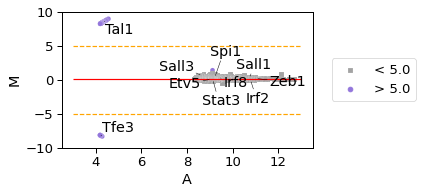

In [133]:
gene_zscore = MA_plot(pd.to_numeric(t1["Topic_12"], errors="coerce"),
        pd.to_numeric(t2["Topic_8"], errors="coerce"),
        size=None,
        pseudocount=1,
        threshold=3,
        cutoff=5.0,
        labels=['Etv5','Zeb1','Sall1','Sall3','Tal1',
               'Tfec','Stat4','Stat6','Foxo1','Runx3',
               'Stat3','Irf2','Irf8','Spi1','Tfe3'],
        save=True,
        show=True,
        file_format="pdf",
        file_name="fig3/fig3c_brain_MA_plot")



# Fig. 3d

In [134]:
top_model_heart = Topyfic.read_analysis("../snrna/heart/topyfic/topModel_10x_heart_11_parse_heart_13.p")


Reading Analysis done!


In [135]:
t1 = top_model_hippocampus.topics['Topic_12'].gene_weights
t2 = top_model_heart.topics['Topic_3'].gene_weights


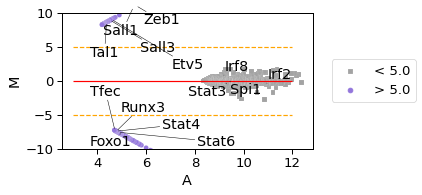

In [136]:
gene_zscore = MA_plot(pd.to_numeric(t1["Topic_12"], errors="coerce"),
        pd.to_numeric(t2["Topic_3"], errors="coerce"),
        size=None,
        pseudocount=1,
        threshold=3,
        cutoff=5.0,
        labels=['Etv5','Zeb1','Sall1','Sall3','Tal1',
               'Tfec','Stat4','Stat6','Foxo1','Runx3',
               'Stat3','Irf2','Irf8','Spi1','Tfe3'],
        save=True,
        show=True,
        file_format="pdf",
        file_name="fig3/fig3d_brain_heart_MA_plot")



# Fig. 3e-k

In [194]:
top_model_paths = {
    "adrenal": "../snrna/adrenal/topyfic/topModel_10x_adrenal_15_parse_adrenal_13.p",
    "cortex": "../snrna/cortex/topyfic/topModel_10x_cortex_14_parse_cortex_13.p",
    "hippocampus": "../snrna/hippocampus/topyfic/topModel_10x_hipp_13_parse_hipp_12.p",
    "heart": "../snrna/heart/topyfic/topModel_10x_heart_11_parse_heart_13.p",
    "gastroc": "../snrna/gastrocnemius/topyfic/topModel_10x_gastrocnemius_12_parse_gastrocnemius_8.p",
}

# Read top models and concatenate gene weights
gene_weights = pd.concat(
    [
        Topyfic.read_analysis(file_path).get_gene_weights()
        for alias, file_path in top_model_paths.items()
    ],
    axis=1,
)

gene_biotype = pd.read_csv("data/gene_display_table_expressed_7categories.csv", index_col=None)
gene_biotype.drop(["keep"], axis=1, inplace=True)
gene_biotype.index = gene_biotype.gene_name

gene_weights = pd.concat([gene_biotype, gene_weights], axis=1)
gene_weights.drop(["gene_name"], axis=1, inplace=True)

Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!


In [189]:
df_plot = gene_weights.copy(deep=True)

gene_weights.drop(["display_name", "biotype"], axis=1, inplace=True)
gene_weights[gene_weights < 1] = 0
gene_weights[gene_weights >= 1] = 1
gene_weights = gene_weights.sum(axis=1)
df_plot['avg'] = gene_weights.values

gene_weights = gene_weights_mean.copy(deep=True)
gene_weights.drop(["avg", "display_name", "biotype"], axis=1, inplace=True)
df_plot['max'] = gene_weights.max(axis=1)

gene_weights = gene_weights_mean.copy(deep=True)
gene_weights.drop(["avg", "display_name", "biotype", "max"], axis=1, inplace=True)
gene_weights[gene_weights < 1] = 0
gene_weights = gene_weights.replace(0, np.NaN)
df_plot['median'] = gene_weights.median(axis=1, skipna=True)

df_plot['percent'] = (df_plot['avg'] / df_plot['avg'].max())*100

In [203]:
i = 0
color_biotypes = ["#D83737", 
                  "#3281B9",
                  "#2AA02B",
                  "#97665D",
                  "#FE7F0F",
                  "#976BBE",
                  "#E279C1"]
biotypes = ['TF',
            'Transcription_regulator',
            'Chromatin_binding',
            'Chromatin_organization',
            'TAF-MED',
            'MiRNA_HG',
            'Histone_modifying_enzyme']


# Create a PDF file to save the plots
pdf_filename = "fig3/fig3e-k_gene_bioype_scatter.pdf"
pdf_pages = matplotlib.backends.backend_pdf.PdfPages(pdf_filename)

for biotype in biotypes:
    df = df_plot[df_plot.biotype == biotype]
    tmp = df_plot.copy(deep=True)
    #print(tmp)
    tmp.drop(["avg", "display_name", "biotype", "max"], axis=1, inplace=True)
    tmp[tmp < 1] = 0
    tmp = tmp.replace(0, np.NaN)
    df['median'] = tmp.median(axis=1, skipna=True)
    
    g = sns.JointGrid(data=df, 
                      y='median', x="percent", hue="biotype",
                      height=3, ratio=3,
                      palette=[color_biotypes[i]],
                      marginal_ticks=True, 
                      xlim = (0,105), ylim = (1,6500))
    
    # Histograms for x and y axes
    hist_kwargs = {
        "color": color_biotypes[i],
        "edgecolor": "black"    }
    
    g.ax_marg_x.hist(df['percent'], **hist_kwargs)
    g.ax_marg_y.hist(df['median'], 
                     bins=range(round(df['median'].min()), round(df['median'].max()), 20), 
                     orientation="horizontal", **hist_kwargs)
    g.plot_joint(sns.scatterplot)
    
    g.ax_joint.axvline(x=50, color='grey', linestyle='--', linewidth = 1)
    g.ax_joint.axhline(y=200, color='grey', linestyle='--', linewidth = 1)
    
    g.ax_joint.tick_params(axis="x", rotation=45)
    
    g.ax_joint.legend_.remove()
    g.ax_joint.set_yscale('log')
    g.ax_joint.set_xlabel('% topics with gene weights >= 1')
    g.ax_joint.set_ylabel('Median of gene weights >= 1')
    
    plt.subplots_adjust(bottom=0.25)
    
    # Adjust spine linewidths for individual axes
    g.ax_joint.spines['top'].set_linewidth(1)
    g.ax_joint.spines['right'].set_linewidth(1)
    g.ax_joint.spines['bottom'].set_linewidth(1)
    g.ax_joint.spines['left'].set_linewidth(1)
    
    g.ax_joint.tick_params(axis='x', which='both', width=1)
    g.ax_joint.tick_params(axis='y', which='both', width=1)
    
    # Change font size of tick labels
    g.ax_joint.tick_params(axis='x', labelsize=12)  # Adjust labelsize as needed
    g.ax_joint.tick_params(axis='y', labelsize=12)  # Adjust labelsize as needed

 
    # Save the current plot to the PDF file
    pdf_pages.savefig(plt.gcf())

    # Clear the plot for the next iteration
    plt.clf()
    
    i += 1
    
# Close the PDF file
pdf_pages.close()

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

In [191]:
res = pd.DataFrame(columns = biotypes,
                   index = ['greater50_greater200',
                            'lower50_greater200',
                            'greater50_lower200',
                            'lower50_lower200'])
for biotype in biotypes:
    df = gene_weights_mean[gene_weights_mean.biotype == biotype]
    tmp = gene_weights_mean.copy(deep=True)
    #print(tmp)
    tmp.drop(["avg", "display_name", "biotype", "max"], axis=1, inplace=True)
    tmp[tmp < 1] = 0
    tmp = tmp.replace(0, np.NaN)
    df['median'] = tmp.median(axis=1, skipna=True)
    res.loc['greater50_greater200', biotype] = df[np.logical_and(df['median'] > 200, df['percent'] > 50)].shape[0]
    res.loc['lower50_greater200', biotype] = df[np.logical_and(df['median'] > 200, df['percent'] <= 50)].shape[0]
    res.loc['greater50_lower200', biotype] = df[np.logical_and(df['median'] <= 200, df['percent'] > 50)].shape[0]
    res.loc['lower50_lower200', biotype] = df[np.logical_and(df['median'] <= 200, df['percent'] <= 50)].shape[0]
print(res)
res = res / res.sum() * 100
res.to_csv("data/fig3e-k_quadrants.csv")
res

                       TF Transcription_regulator Chromatin_binding  \
greater50_greater200  119                      49               108   
lower50_greater200    467                     140               169   
greater50_lower200      0                       0                 0   
lower50_lower200      211                      46                46   

                     Chromatin_organization TAF-MED MiRNA_HG  \
greater50_greater200                     64      20       30   
lower50_greater200                      111      62      105   
greater50_lower200                        0       0        0   
lower50_lower200                         42      19       13   

                     Histone_modifying_enzyme  
greater50_greater200                       40  
lower50_greater200                         54  
greater50_lower200                          0  
lower50_lower200                           19  


,TF,Transcription_regulator,Chromatin_binding,Chromatin_organization,TAF-MED,MiRNA_HG,Histone_modifying_enzyme
greater50_greater200,14.930991,20.851064,33.436533,29.493088,19.80198,20.27027,35.39823
lower50_greater200,58.59473,59.574468,52.321981,51.152074,61.386139,70.945946,47.787611
greater50_lower200,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lower50_lower200,26.474279,19.574468,14.241486,19.354839,18.811881,8.783784,16.814159


# Fig. 3L

In [2]:
import Topyfic
import pandas as pd
import scanpy as sc
import numpy as np
import random
import seaborn as sns
import anndata
import pandas as pd
from simplex_plot import *



In [3]:
analysis_adrenal = Topyfic.read_analysis("../snrna/adrenal/topyfic/analysis_10x_adrenal_15_parse_adrenal_13.p")
analysis_hippocampus = Topyfic.read_analysis("../snrna/hippocampus/topyfic/analysis_10x_hipp_13_parse_hipp_12.p")
analysis_gastroc = Topyfic.read_analysis("../snrna/gastrocnemius/topyfic/analysis_10x_gastrocnemius_12_parse_gastrocnemius_8.p")
analysis_cortex = Topyfic.read_analysis("../snrna/cortex/topyfic/analysis_10x_cortex_14_parse_cortex_13.p")
analysis_heart = Topyfic.read_analysis("../snrna/heart/topyfic/analysis_10x_heart_11_parse_heart_13.p")


top_model_adrenal = Topyfic.read_analysis("../snrna/adrenal/topyfic/topModel_10x_adrenal_15_parse_adrenal_13.p")
top_model_hippocampus = Topyfic.read_analysis("../snrna/hippocampus/topyfic/topModel_10x_hipp_13_parse_hipp_12.p")
top_model_gastroc = Topyfic.read_analysis("../snrna/gastrocnemius/topyfic/topModel_10x_gastrocnemius_12_parse_gastrocnemius_8.p")
top_model_cortex = Topyfic.read_analysis("../snrna/cortex/topyfic/topModel_10x_cortex_14_parse_cortex_13.p")
top_model_heart = Topyfic.read_analysis("../snrna/heart/topyfic/topModel_10x_heart_11_parse_heart_13.p")

topModels = [top_model_adrenal,
            top_model_hippocampus,
            top_model_gastroc,
            top_model_cortex,
            top_model_heart]




Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!


In [4]:
######### Get gene weights #########

all_gene_weights = None

for topModel in topModels:
    gene_weights = topModel.get_gene_weights()
    if all_gene_weights is None:
        all_gene_weights = gene_weights
    else:
        all_gene_weights = pd.concat([gene_weights, all_gene_weights], axis=1)

topModels_label = dict()
for topModel in topModels:
    for i in range(topModel.N):
        key = f"{topModel.name}_Topic_{i+1}"
        if "adrenal" in topModel.name:
            value = f"AD{i+1}"
        if "hipp" in topModel.name:
            value = f"HC{i+1}"
        if "cortex" in topModel.name:
            value = f"CX{i+1}"
        if "heart" in topModel.name:
            value = f"HT{i+1}"
        if "gastrocnemius" in topModel.name:
            value = f"GC{i+1}"
        topModels_label[key] = value
        
all_gene_weights.rename(columns=topModels_label, inplace=True)

gene_biotype = pd.read_csv("data/gene_display_table.csv", index_col=0)
gene_biotype.index = gene_biotype.gene_name
all_gene_weights = pd.concat([gene_biotype, all_gene_weights], axis=1)
all_gene_weights.drop(["gene_name", "display_name", "biotype"], axis=1, inplace=True)

for col in all_gene_weights.columns[1:]:
    a = all_gene_weights.sort_values([col], ascending=False).index.tolist()[100:]
    all_gene_weights.loc[a, col] = np.nan
    all_gene_weights[col][all_gene_weights[col] <= all_gene_weights[col].min()] = np.nan




In [5]:
######### Make df #########
    
res = pd.DataFrame(index=all_gene_weights.columns.tolist()[1:],
                   columns=all_gene_weights.cat_biotype.unique().tolist())
for topic in res.index:
    for biotype in res.columns:
        res.loc[topic, biotype] = all_gene_weights[all_gene_weights.cat_biotype == biotype][topic].sum(skipna=True)

res = res.div(res.sum(axis=1), axis=0)

res['cell_participation'] = 0
heart = analysis_heart.cell_participation.to_df().mean()
adrenal = analysis_adrenal.cell_participation.to_df().mean()
cortex = analysis_cortex.cell_participation.to_df().mean()
hippocampus = analysis_hippocampus.cell_participation.to_df().mean()
gastroc = analysis_gastroc.cell_participation.to_df().mean()
for col in all_gene_weights.columns[1:]:
    if 'HT' in col:
        tmp = col.replace('HT', 'Topic_')
        res.loc[col, 'cell_participation'] = heart[tmp]
    if 'HC' in col:
        tmp = col.replace('HC', 'Topic_')
        res.loc[col, 'cell_participation'] = hippocampus[tmp]
    if 'CX' in col:
        tmp = col.replace('CX', 'Topic_')
        res.loc[col, 'cell_participation'] = cortex[tmp]
    if 'AD' in col:
        tmp = col.replace('AD', 'Topic_')
        res.loc[col, 'cell_participation'] = adrenal[tmp]
    if 'GC' in col:
        tmp = col.replace('GC', 'Topic_')
        res.loc[col, 'cell_participation'] = gastroc[tmp]
        
res.to_csv("data/fig3_norm_mean_top100_gene_weight_topic_biotype.csv")




In [6]:
######### Make plotting df #########

topic_fname = 'data/fig3_norm_mean_top100_gene_weight_topic_biotype.csv'
df = pd.read_csv(topic_fname)
df.rename({'Unnamed: 0': 'Topic'}, axis=1, inplace=True)
df.set_index('Topic', inplace=True)

groups = {'Chromatin': ['Chromatin Organization', 'Chromatin Binding'],
          'TF, miRNA': ['Transcription Factor', 'miRNA host gene'],
          'Other': ['TAF-Mediator', 'Histone Modifying Enzyme', 'Transcription Regulator']}
drop_cols = df.columns.tolist()[:-1]
for key, item in groups.items():
    df[key] = df[item].sum(axis=1)
    
df.drop(drop_cols, axis=1, inplace=True)
df['color'] = df.index.tolist()
df.color[df.color.str.contains("HT")] = "HT"
df.color[df.color.str.contains("HC")] = "HC"
df.color[df.color.str.contains("CX")] = "CX"
df.color[df.color.str.contains("AD")] = "AD"
df.color[df.color.str.contains("GC")] = "GC"

df['cell_participation'] = df['cell_participation'] * 100

df.to_csv("data/fig3_simplex_df.csv")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,cell_participation,Chromatin,"TF, miRNA",Other,color,cell_participation_log
Topic,,,,,,
HT1,15.899535,0.321672,0.493432,0.184896,HT,1.201384
HT2,10.041537,0.267253,0.441795,0.290952,HT,1.001800
HT3,4.634521,0.334641,0.442914,0.222446,HT,0.666005
HT4,7.080410,0.394135,0.278239,0.327627,HT,0.850058
HT5,0.840541,0.378356,0.421639,0.200006,HT,-0.075441
...,...,...,...,...,...,...
AD15,1.299771,0.298226,0.500898,0.200876,AD,0.113867
AD16,0.804789,0.277785,0.508255,0.213959,AD,-0.094318
AD17,0.488100,0.291575,0.501299,0.207126,AD,-0.311491


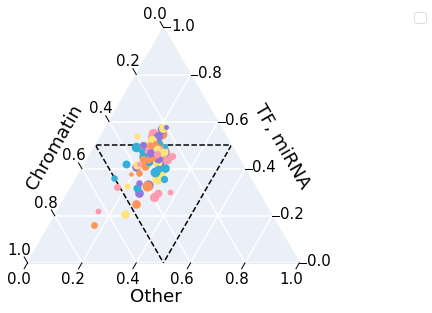

In [7]:
######### Plot simplex #########

plot_simplex(df,
             left=df.columns[1],
             right=df.columns[2],
             bottom=df.columns[3],
             hue=df.columns[4],
             cmap={'AD': '#ff9458',
                   'CX': '#ffe578',
                   'HC': '#9376dc',
                   'GC': '#34b0d8',
                   'HT': '#ff9aaf'},
             scatter=True,
             sectors=True,
             size_scale=0.5,
             size=df.columns[0],
             log_size=True,
             fname="fig3/fig3l_simplex_top100.pdf")

# Fig. 3m

In [3]:
def compare_topModels(topModels,
                      comparison_method="Jensen–Shannon divergence",
                      output_type='graph',
                      threshold=0.8,
                      topModels_color=None,
                      topModels_label=None,
                      ignore_genes=True,
                      save=False,
                      plot_show=True,
                      figsize=None,
                      plot_format="pdf",
                      file_name="compare_topics"):
    """
    compare topModels using topic gene weights

    :param topModels: list of topModel class you want to compare to each other
    :type topModels: list of TopModel class
    :param comparison_method: indicate the method you want to use for comparing topics. if you used Jensen–Shannon, we show -log2 (options: pearson correlation, spearman correlation, Jensen–Shannon divergence, cosine similarity)
    :type comparison_method: str
    :param output_type: indicate the type of output you want. graph: plot as a graph, heatmap: plot as a heatmap, table: table contains correlation. Note: if you want to plot Jensen–Shannon divergence as a graph, we convert the values to be at the -log2(), so you need to take that account for defining threshold
    :type output_type: str
    :param threshold: only apply when you choose circular which only show correlation above that
    :type threshold: float
    :param topModels_color: dictionary of colors mapping each topics to each color (default: blue)
    :type topModels_color: dict
    :param topModels_label: dictionary of label mapping each topics to each label
    :type topModels_label: dict
    :param ignore_genes: idicate how to behave to the genes that only represent in one the topics. "True" means it's gonna ignore those genes and "False" means it's gonna asumne the weights are zero for those genes that we don't have any weights in one of the mouse models
    :type ignore_genes: bool
    :param save: indicate if you want to save the plot or not (default: True)
    :type save: bool
    :param plot_show: indicate if you want to show the plot or not (default: True)
    :type plot_show: bool
    :param figsize: indicate the size of plot (default: (10 * (len(category) + 1), 10))
    :type figsize: tuple of int
    :param plot_format: indicate the format of plot (default: pdf)
    :type plot_format: str
    :param file_name: name and path of the plot use for save (default: compare_topics)
    :type file_name: str

    :return: table contains correlation between topics only when table is choose and save is False
    :rtype: pandas dataframe
    """
    if output_type not in ['graph', 'heatmap', 'table']:
        sys.exit("output_type is not valid! it should be one of 'graph', 'heatmap', or 'table'")

    if comparison_method not in ['spearman correlation', 'pearson correlation', 'Jensen–Shannon divergence', 'cosine similarity']:
        sys.exit("comparison_method is not valid! it should be one of 'spearman correlation', 'pearson correlation', or 'Jensen–Shannon divergence'")

    names = [topModel.name for topModel in topModels]
    if len(names) != len(set(names)):
        sys.exit("Name of the TopModels should be unique!")

    all_gene_weights = None

    for topModel in topModels:
        gene_weights = topModel.get_gene_weights()
        if all_gene_weights is None:
            all_gene_weights = gene_weights
        else:
            all_gene_weights = pd.concat([gene_weights, all_gene_weights], axis=1)

    corrs = pd.DataFrame(index=all_gene_weights.columns,
                         columns=all_gene_weights.columns,
                         dtype='float64')

    for d1 in all_gene_weights.columns.tolist():
        for d2 in all_gene_weights.columns.tolist():
            if d1 == d2:
                corrs.at[d1, d2] = 1
                continue
            a = all_gene_weights[[d1, d2]]
            if ignore_genes:
                a.dropna(axis=0, how='any', inplace=True)
            else:
                a.dropna(axis=0, how='all', inplace=True)
                a.fillna(0, inplace=True)

            a = a[np.logical_or(a[d1] > a[d1].min(), a[d2] > a[d2].min())]
            a = a / a.sum()
            if comparison_method == "Jensen–Shannon divergence":
                JSd = distance.jensenshannon(a[d1].tolist(), a[d2].tolist())
                corrs.loc[d1, d2] = JSd * JSd
            elif comparison_method == "pearson correlation":
                corr = st.pearsonr(a[d1].tolist(), a[d2].tolist())
                corrs.at[d1, d2] = corr[0]
            elif comparison_method == "spearman correlation":
                corr = st.spearmanr(a[d1].tolist(), a[d2].tolist())
                corrs.at[d1, d2] = corr[0]
            elif comparison_method == 'cosine similarity':
                corr = distance.cosine(a[d1].tolist(), a[d2].tolist())
                corrs.at[d1, d2] = 1 - corr
    if comparison_method == "Jensen–Shannon divergence":
        corrs = corrs.applymap(math.log2)
        corrs = corrs * -1

    if output_type == 'table':
        if save:
            corrs.to_csv(f"{file_name}.csv")
        else:
            return corrs

    if output_type == 'heatmap':
        if topModels_label is not None:
            corrs.rename(columns=topModels_label, index=topModels_label, inplace=True)
        sns.clustermap(corrs,
                       figsize=figsize)
        if save:
            plt.savefig(f"{file_name}.{plot_format}")
        if plot_show:
            plt.show()
        else:
            plt.close()

        return

    if output_type == 'graph':
        np.fill_diagonal(corrs.values, 0)
        corrs[corrs < threshold] = np.nan
        res = corrs.stack()
        res = pd.DataFrame(res)
        res.reset_index(inplace=True)
        res.columns = ['source', 'dest', 'weight']
        res['weight'] = res['weight'].astype(float).round(decimals=2)
        res['source_label'] = res['source']
        res['dest_label'] = res['dest']
        res['source_color'] = res['source']
        res['dest_color'] = res['dest']

        if topModels_label is not None:
            res['source_label'].replace(topModels_label, inplace=True)
            res['dest_label'].replace(topModels_label, inplace=True)
        if topModels_color is None:
            res['source_color'] = "blue"
            res['dest_color'] = "blue"
        else:
            res['source_color'].replace(topModels_color, inplace=True)
            res['dest_color'].replace(topModels_color, inplace=True)

        G = nx.Graph()
        for i in range(res.shape[0]):
            G.add_node(res.source_label[i], color=res.source_color[i])
            G.add_node(res.dest_label[i], color=res.dest_color[i])
            G.add_edge(res.source_label[i], res.dest_label[i], weight=res.weight[i])

        connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

        if figsize is None:
            figsize = (len(connected_components) * 2, len(connected_components) * 2)

        nrows = math.ceil(math.sqrt(len(connected_components)))
        ncols = math.ceil(len(connected_components) / nrows)
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor='white')

        i = 0
        for connected_component in connected_components:
            g_connected_component = G.subgraph(connected_component)
            nodePos = nx.spring_layout(g_connected_component)

            edge_labels = nx.get_edge_attributes(g_connected_component, "weight")

            node_color = nx.get_node_attributes(g_connected_component, "color").values()
            weights = nx.get_edge_attributes(g_connected_component, 'weight').values()

            if len(connected_components) == 1:
                ax = axs
            elif ncols == 1:
                ax = axs[int(i / ncols)]
            else:
                ax = axs[int(i / ncols), i % ncols]

            nx.draw_networkx(g_connected_component,
                             pos=nodePos,
                             width=list(weights),
                             with_labels=True,
                             node_color=list(node_color),
                             font_size=8,
                             node_size=500,
                            # font_family='Arial',
                             ax=ax)

            nx.draw_networkx_edge_labels(g_connected_component,
                                         nodePos,
                                         edge_labels=edge_labels,
                                         font_size=7,
                                         ax=ax)

            i += 1

        if len(connected_components) == 1:
            ax.axis('off')
        else:
            [axi.axis('off') for axi in axs.ravel()]
        plt.tight_layout()
        if save:
            plt.savefig(f"{file_name}.{plot_format}")
        if plot_show:
            plt.show()
        else:
            plt.close()

        return axs

In [4]:
top_model_adrenal = Topyfic.read_analysis("../snrna/adrenal/topyfic/topModel_10x_adrenal_15_parse_adrenal_13.p")
top_model_cortex = Topyfic.read_analysis("../snrna/cortex/topyfic/topModel_10x_cortex_14_parse_cortex_13.p")
top_model_hippocampus = Topyfic.read_analysis("../snrna/hippocampus/topyfic/topModel_10x_hipp_13_parse_hipp_12.p")
top_model_heart = Topyfic.read_analysis("../snrna/heart/topyfic/topModel_10x_heart_11_parse_heart_13.p")
top_model_gastroc = Topyfic.read_analysis("../snrna/gastrocnemius/topyfic/topModel_10x_gastrocnemius_12_parse_gastrocnemius_8.p")

topModels = [top_model_adrenal,
             top_model_cortex,
             top_model_hippocampus,
             top_model_heart,
             top_model_gastroc]


Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!
Reading Analysis done!


In [5]:
topModels_color = dict()
for topModel in topModels:
    for i in range(topModel.N):
        key = f"{topModel.name}_Topic_{i+1}"
        if "adrenal" in topModel.name:
            value = "#ff9458"
        if "hipp" in topModel.name:
            value = "#9376dc"
        if "cortex" in topModel.name:
            value = "#ffe578"
        if "heart" in topModel.name:
            value = "#ff9aaf"
        if "gastrocnemius" in topModel.name:
            value = "#34b0d8"
        topModels_color[key] = value

In [6]:
topModels_label = dict()
for topModel in topModels:
    for i in range(topModel.N):
        key = f"{topModel.name}_Topic_{i+1}"
        if "adrenal" in topModel.name:
            value = f"AD{i+1}"
        if "hipp" in topModel.name:
            value = f"HC{i+1}"
        if "cortex" in topModel.name:
            value = f"CX{i+1}"
        if "heart" in topModel.name:
            value = f"HT{i+1}"
        if "gastrocnemius" in topModel.name:
            value = f"GC{i+1}"
        topModels_label[key] = value
        

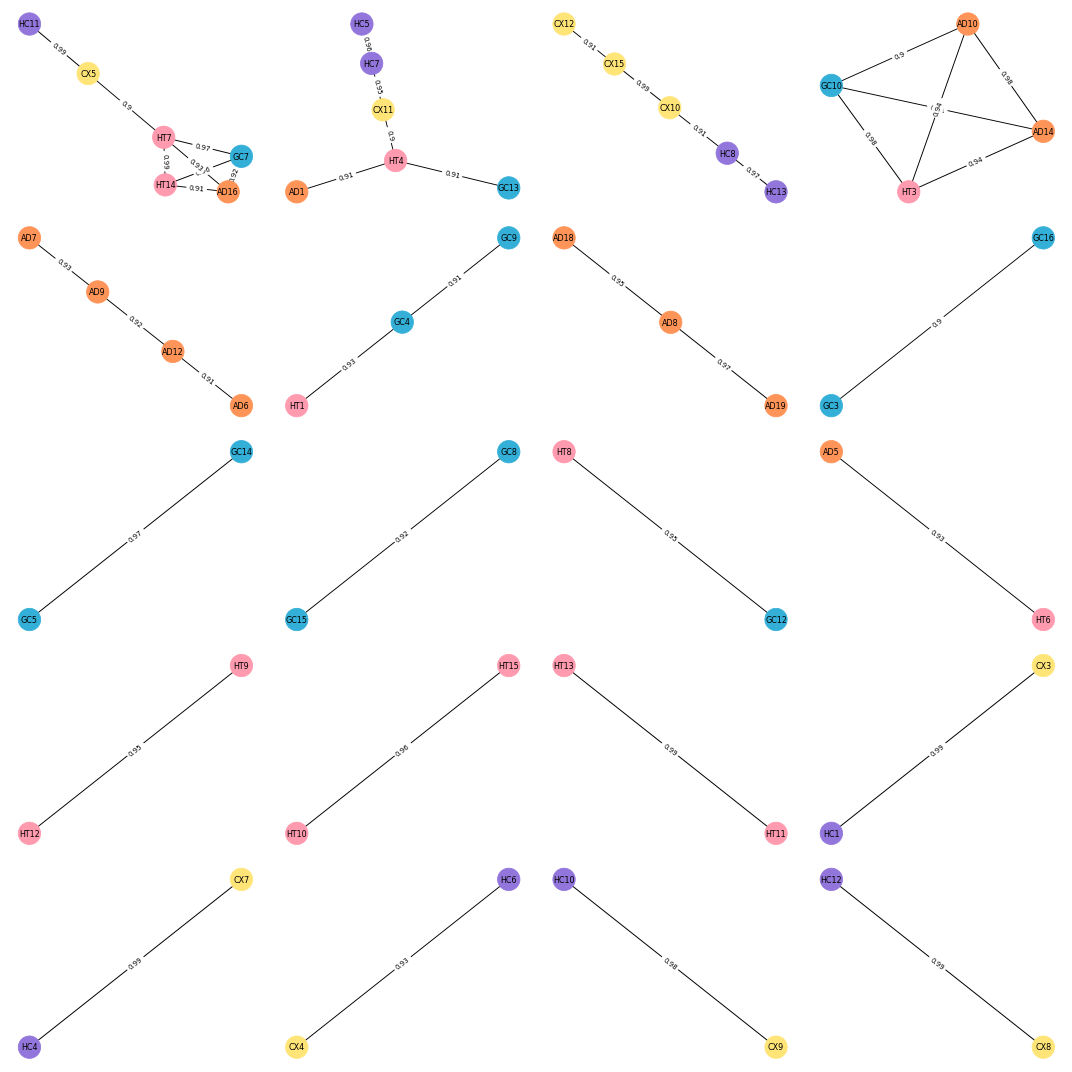

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

In [7]:
compare_topModels(topModels=topModels,
                          comparison_method='cosine similarity',
                          threshold=0.9,
                          figsize=(15,15),
                          topModels_label=topModels_label,
                          topModels_color=topModels_color,
                          save=True,
                          file_name="fig3/fig3m_cosine_similarity_clusters",
                          output_type='graph')


In [8]:
compare_topModels(topModels=topModels,
                          comparison_method='cosine similarity',
                          threshold=0.9,
                          topModels_label=topModels_label,
                          topModels_color=topModels_color,
                          save=True,
                          file_name="fig3/fig3m_cosine_similarity_clusters",
                          output_type='table')
